# **Fourier & Sage**
**_A project by Felix Lentze & Dominic Plein ([@Splience](https://youtube.com/@splience))_**

In this project, we will discuss what sound is, how to represent it mathematically & in a computer, and how to examine its frequency content using the Fourier Transform. The latter will be implemented in SageMath, a free open-source computer algebra system as superset of Python which bundles many great libraries like numpy, scipy, matplotlib, and more. With the help of filter matrices, the frequency spectrum of a sound can be manipulated. This is demonstrated with some sample sounds.

This projected is intended for educational purposes, i.e. the don't focus on performance of our code (for that, see the FFT algorithm implemented in system-level languages like Rust or C++). Basic knowledge of linear algebra as well as Python are required. The key points are explained next to the code. The reader is encouraged to experiment with the code and the provided sound samples.

### **DFT**

Importing important libarys and implementing DFT function 

In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

def dft(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

### **`.wav`-file**

Importing .wav-file and printing length of the vector and sample rate

Vector containing air pressure differences at different (discrete) time steps
Sample rate says how many samples per second the .wav-file contains (normally 44100)

In [3]:
sample_rate, wav_data = wavfile.read('./data/sounds/sin04.wav')
print(len(wav_data))
print(wav_data)
print(sample_rate)

FileNotFoundError: [Errno 2] No such file or directory: './data/sounds/sin04.wav'

### **Fourier transformation**

performing DFT on wav-Vector. 
dft_result contains "frequencies" ( = periodic functions with given frequency) and quantity of frequence in measured signal

In [49]:
dft_result = np.fft.fft(wav_data)
print(dft_result)
n = len(dft_result)
n

[13419.        +0.j         13418.9764895 +0.58301121j
 13418.90598913+1.16282557j ... 13418.78859742-1.73621184j
 13418.90598913-1.16282557j 13418.9764895 -0.58301121j]


17641

Determine occuring frequencies

In [50]:
n = len(wav_data)
print(n) 
freqs = np.fft.fftfreq(n)
print(freqs) 

17641
[ 0.00000000e+00  5.66861289e-05  1.13372258e-04 ... -1.70058387e-04
 -1.13372258e-04 -5.66861289e-05]


### **Plot**

Creating plot with amplitude of frequencies

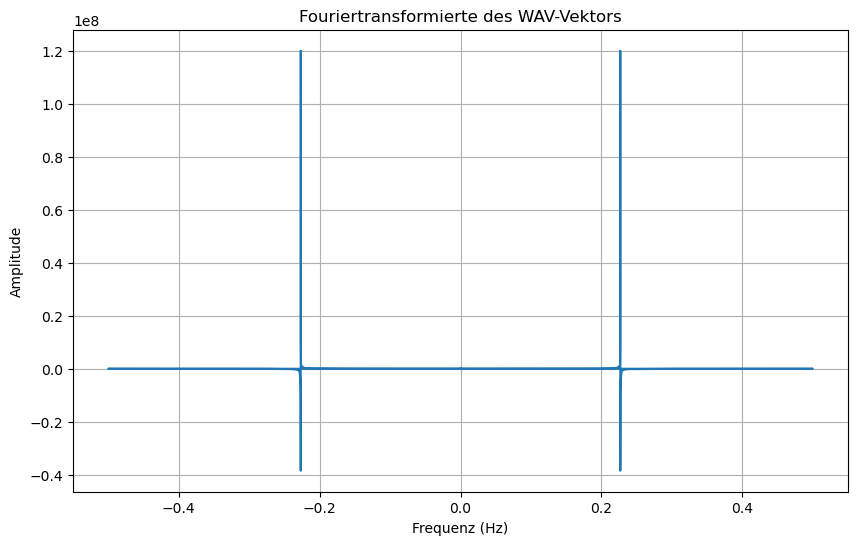

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.real(dft_result))  # Nur die positive Frequenzhälfte
plt.title('Fouriertransformierte des WAV-Vektors')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### **Inverse Discrete Fourier Transform (IDFT)**


In [52]:
#IDFT
def idft(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return (1/N)*X

In [53]:
idft_result = idft(dft_result)
len(idft_result)
idft_result

array([-8.85985287e-12+1.49917013e-11j,  2.29240000e+04-2.76282277e-11j,
        6.67200000e+03-1.27796246e-12j, ...,
       -3.00000000e+01+9.34070367e-09j, -5.19999999e+01-5.98812655e-08j,
        2.34595155e-08-6.15965873e-09j])

### **Fix rounding issues**

In [54]:
idft_rounded = np.around(idft_result, 6) #6 -> ok, 7 -> not ok

if np.array_equal(wav_data, idft_rounded):
    print("ok")
else:
    print("not ok")

ok


### **`.wav` output**

In [55]:
samples = idft_rounded
fs = 44100
out_f = 'output.wav'

wavfile.write(out_f, fs, samples)

ValueError: Unsupported data type 'complex128'